# <center>ONLINE PAYMENT FRAUD DETECTION</center>
# <center>Assignment 4: SVM</center>

| Course | Instructor | Full Name | Date       | Term   |
|--------|------------|-----------|------------|--------|
| ALY6040 | Dr Chinthaka Pathum Dinesh, Prof Herath Gedara, Faculty Lecturer | Abhilash Dikshit | May 10, 2023 | Winter |


In [44]:
# Basic Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from sklearn.compose import make_column_selector as selector
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

warnings.filterwarnings(action='ignore')

In [45]:
# Read in the CSV file
path = '~/GitProjects/Datasets/online_payment_fraud_detection.csv'
df_raw = pd.read_csv(path)

In [76]:
display(df_raw)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


### Exploratory Data Analysis

In [47]:
print('\033[1mOnline payment fraud detection:\n' + '='*32 + '\033[0m')
table = [['Type', 'Length', 'Shape'], [type(df_raw), len(df_raw), df_raw.shape]]
print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))

Online payment fraud detection:
╒═══════════════════════════════════════╤══════════╤═══════════════╕
│ Type                                  │   Length │ Shape         │
╞═══════════════════════════════════════╪══════════╪═══════════════╡
│ <class 'pandas.core.frame.DataFrame'> │  6362620 │ (6362620, 11) │
╘═══════════════════════════════════════╧══════════╧═══════════════╛


In [48]:
# Split the dataset into training and testing sets (80:20)
train, test = train_test_split(df_raw, test_size=0.2, random_state=42)

# Print the lengths of the training and testing sets
print("Length of training set:", len(train))
print("Length of testing set:", len(test))

Length of training set: 5090096
Length of testing set: 1272524


In [49]:
df = test # we are using test dataset as the train dataset is huge and it is crashing local machine
#print("Length of training set:", len(df))

In [50]:
print('\033[1mEDA on test dataset due to large data:\n' + '='*38 + '\033[0m')

# Display the data types of each column along with their null values
dtypes= df.dtypes

# Check for null values in each column
null_counts = df.isnull().sum()

# number of unique values in each column
uniq= df.nunique()

# Rename columns
combine_details = pd.concat([dtypes, null_counts, uniq], axis=1)
combine_details = combine_details.rename(columns={0: 'Datatype', 1: 'Null_Count', 2: 'Unique_Value'})

# Print result
print(combine_details)

print('\n\033[1mDisplay Dataset:\033[0m \n')
display(df)

print('\n\033[1mDataset Description:\033[0m \n', df.describe())


EDA on test dataset due to large data:
               Datatype  Null_Count  Unique_Value
step              int64           0           697
type             object           0             5
amount          float64           0       1219164
nameOrig         object           0       1272160
oldbalanceOrg   float64           0        460453
newbalanceOrig  float64           0        548278
nameDest         object           0        777464
oldbalanceDest  float64           0        729323
newbalanceDest  float64           0        765658
isFraud           int64           0             2
isFlaggedFraud    int64           0             2

Display Dataset: 



,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3737323,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,0
264914,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,0
85647,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,0
5899326,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,0
2544263,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2210524,186,PAYMENT,917.99,C409548237,9606.00,8688.01,M1829204703,0.00,0.00,0,0
956542,44,PAYMENT,480.58,C1374108622,4683.00,4202.42,M1285472891,0.00,0.00,0,0
5474798,379,CASH_OUT,248511.67,C1966155172,507.00,0.00,C1465953419,23807.93,272319.61,0,0
878120,42,CASH_OUT,200008.65,C1490328004,0.00,0.00,C2003672404,589973.64,789982.29,0,0



Dataset Description: 
                step        amount  oldbalanceOrg  newbalanceOrig  \
count  1.272524e+06  1.272524e+06   1.272524e+06    1.272524e+06   
mean   2.434153e+02  1.802790e+05   8.358581e+05    8.573116e+05   
std    1.423745e+02  6.127373e+05   2.893421e+06    2.929707e+06   
min    1.000000e+00  0.000000e+00   0.000000e+00    0.000000e+00   
25%    1.560000e+02  1.336609e+04   0.000000e+00    0.000000e+00   
50%    2.390000e+02  7.489837e+04   1.432206e+04    0.000000e+00   
75%    3.350000e+02  2.090111e+05   1.073550e+05    1.446149e+05   
max    7.420000e+02  6.933732e+07   4.489219e+07    3.894623e+07   

       oldbalanceDest  newbalanceDest       isFraud  isFlaggedFraud  
count    1.272524e+06    1.272524e+06  1.272524e+06    1.272524e+06  
mean     1.105138e+06    1.229909e+06  1.273060e-03    2.357519e-06  
std      3.428096e+06    3.704978e+06  3.565727e-02    1.535420e-03  
min      0.000000e+00    0.000000e+00  0.000000e+00    0.000000e+00  
25%      0.00

In [51]:
# To check the total fraud in the dataset
print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset


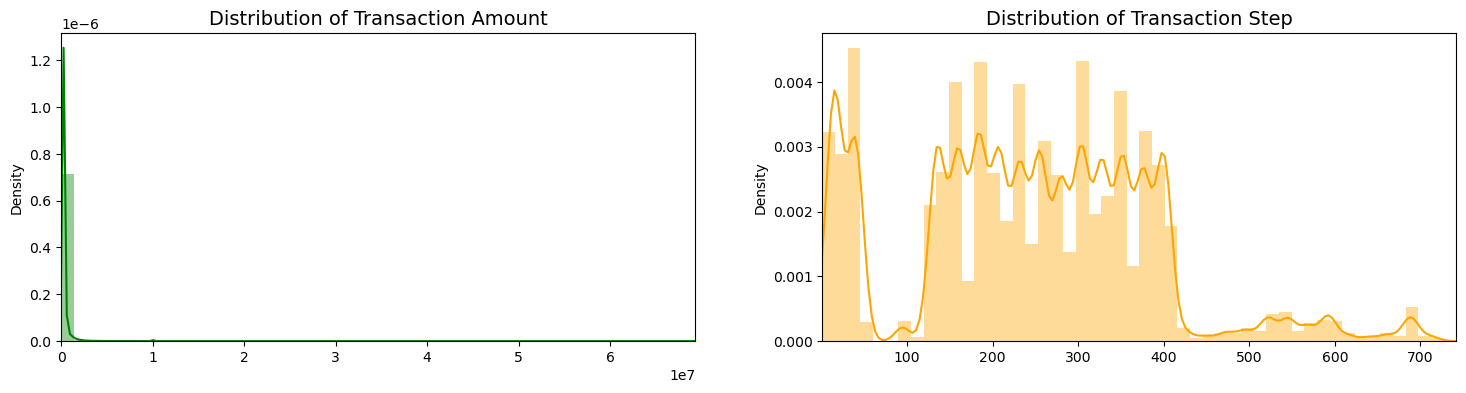

In [52]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))

amount_val = df['amount'].values
time_val = df['step'].values

sns.distplot(amount_val, ax=ax[0], color='g')
sns.distplot(time_val, ax=ax[1], color='orange')

ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

ax[1].set_title('Distribution of Transaction Step', fontsize=14)
ax[1].set_xlim([min(time_val), max(time_val)])

plt.show()

### Countplot to show Payment Type vs Count:

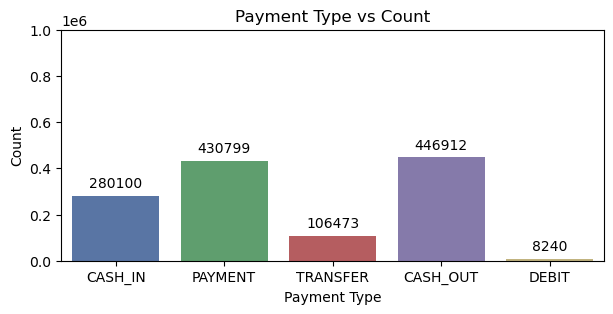

In [53]:
# Countplot of 'type'
plt.figure(figsize=(7,3))
plt.title('Payment Type vs Count')

# Set the color palette
colors = ['#4c72b0', '#55a868', '#c44e52', '#8172b2', '#ccb974', '#64b5cd']

ax = sns.countplot(df, x='type', palette=colors)
plt.xlabel('Payment Type')
plt.ylabel('Count')
plt.ylim(0, 1e6)


# Add count labels to the plot
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points')
    
plt.show()


### Countplot to show the Frequency of Transaction Types where Fraud happened:

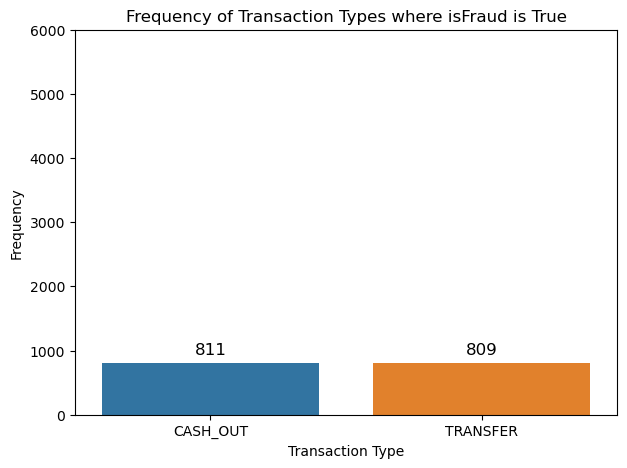

In [54]:
# Create a subset of the data where isFraud is true
fraud_data = df[df['isFraud'] == 1]

# Create a countplot to show the frequency of each transaction type
plt.figure(figsize=(7,5))
ax = sns.countplot(data=fraud_data, x='type')
plt.title('Frequency of Transaction Types where isFraud is True')
plt.xlabel('Transaction Type')
plt.ylim(0, 6000)
plt.ylabel('Frequency')

# Add count values to each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 9),
                textcoords = 'offset points',
                fontsize=12)

plt.show()


In [55]:
# Separate data into numerical and categorical data
numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(df)
categorical_columns = categorical_columns_selector(df)

In [56]:
numerical = ['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest']

categorical = ['type', 'nameOrig', 'nameDest', 'isFlaggedFraud']

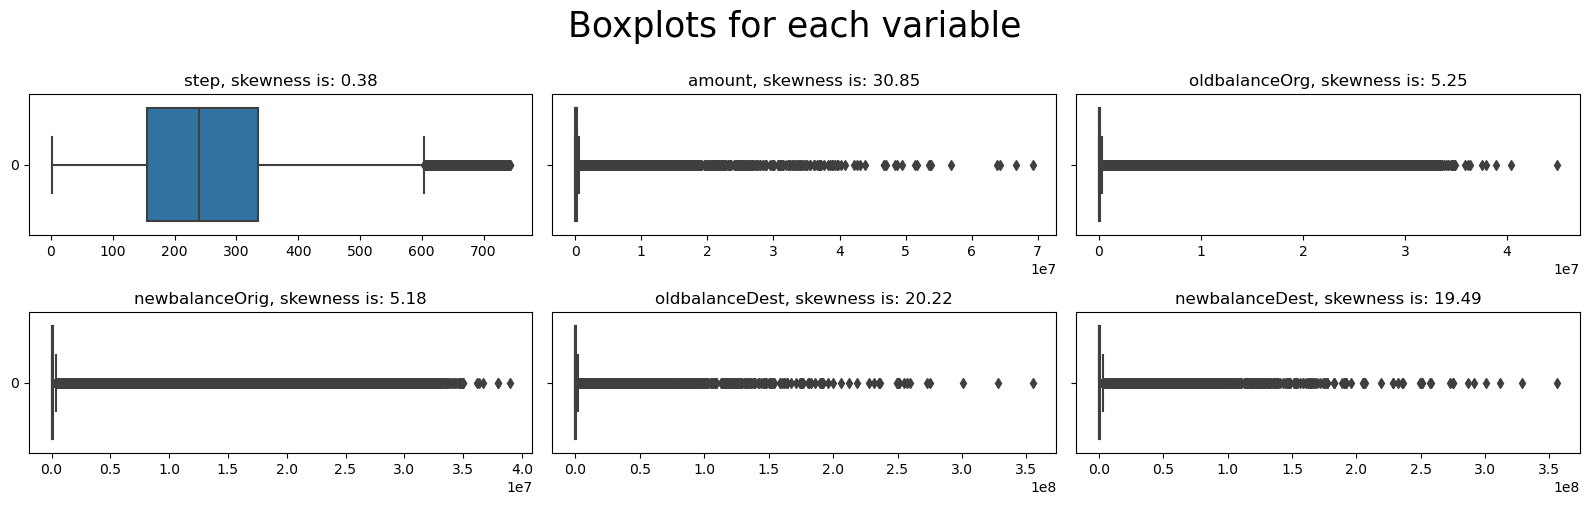

In [57]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,5))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numerical, rows=2, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

[Text(0, 0.5, 'step'),
 Text(0, 1.5, 'amount'),
 Text(0, 2.5, 'oldbalanceOrg'),
 Text(0, 3.5, 'newbalanceOrig'),
 Text(0, 4.5, 'oldbalanceDest'),
 Text(0, 5.5, 'newbalanceDest'),
 Text(0, 6.5, 'isFraud'),
 Text(0, 7.5, 'isFlaggedFraud')]

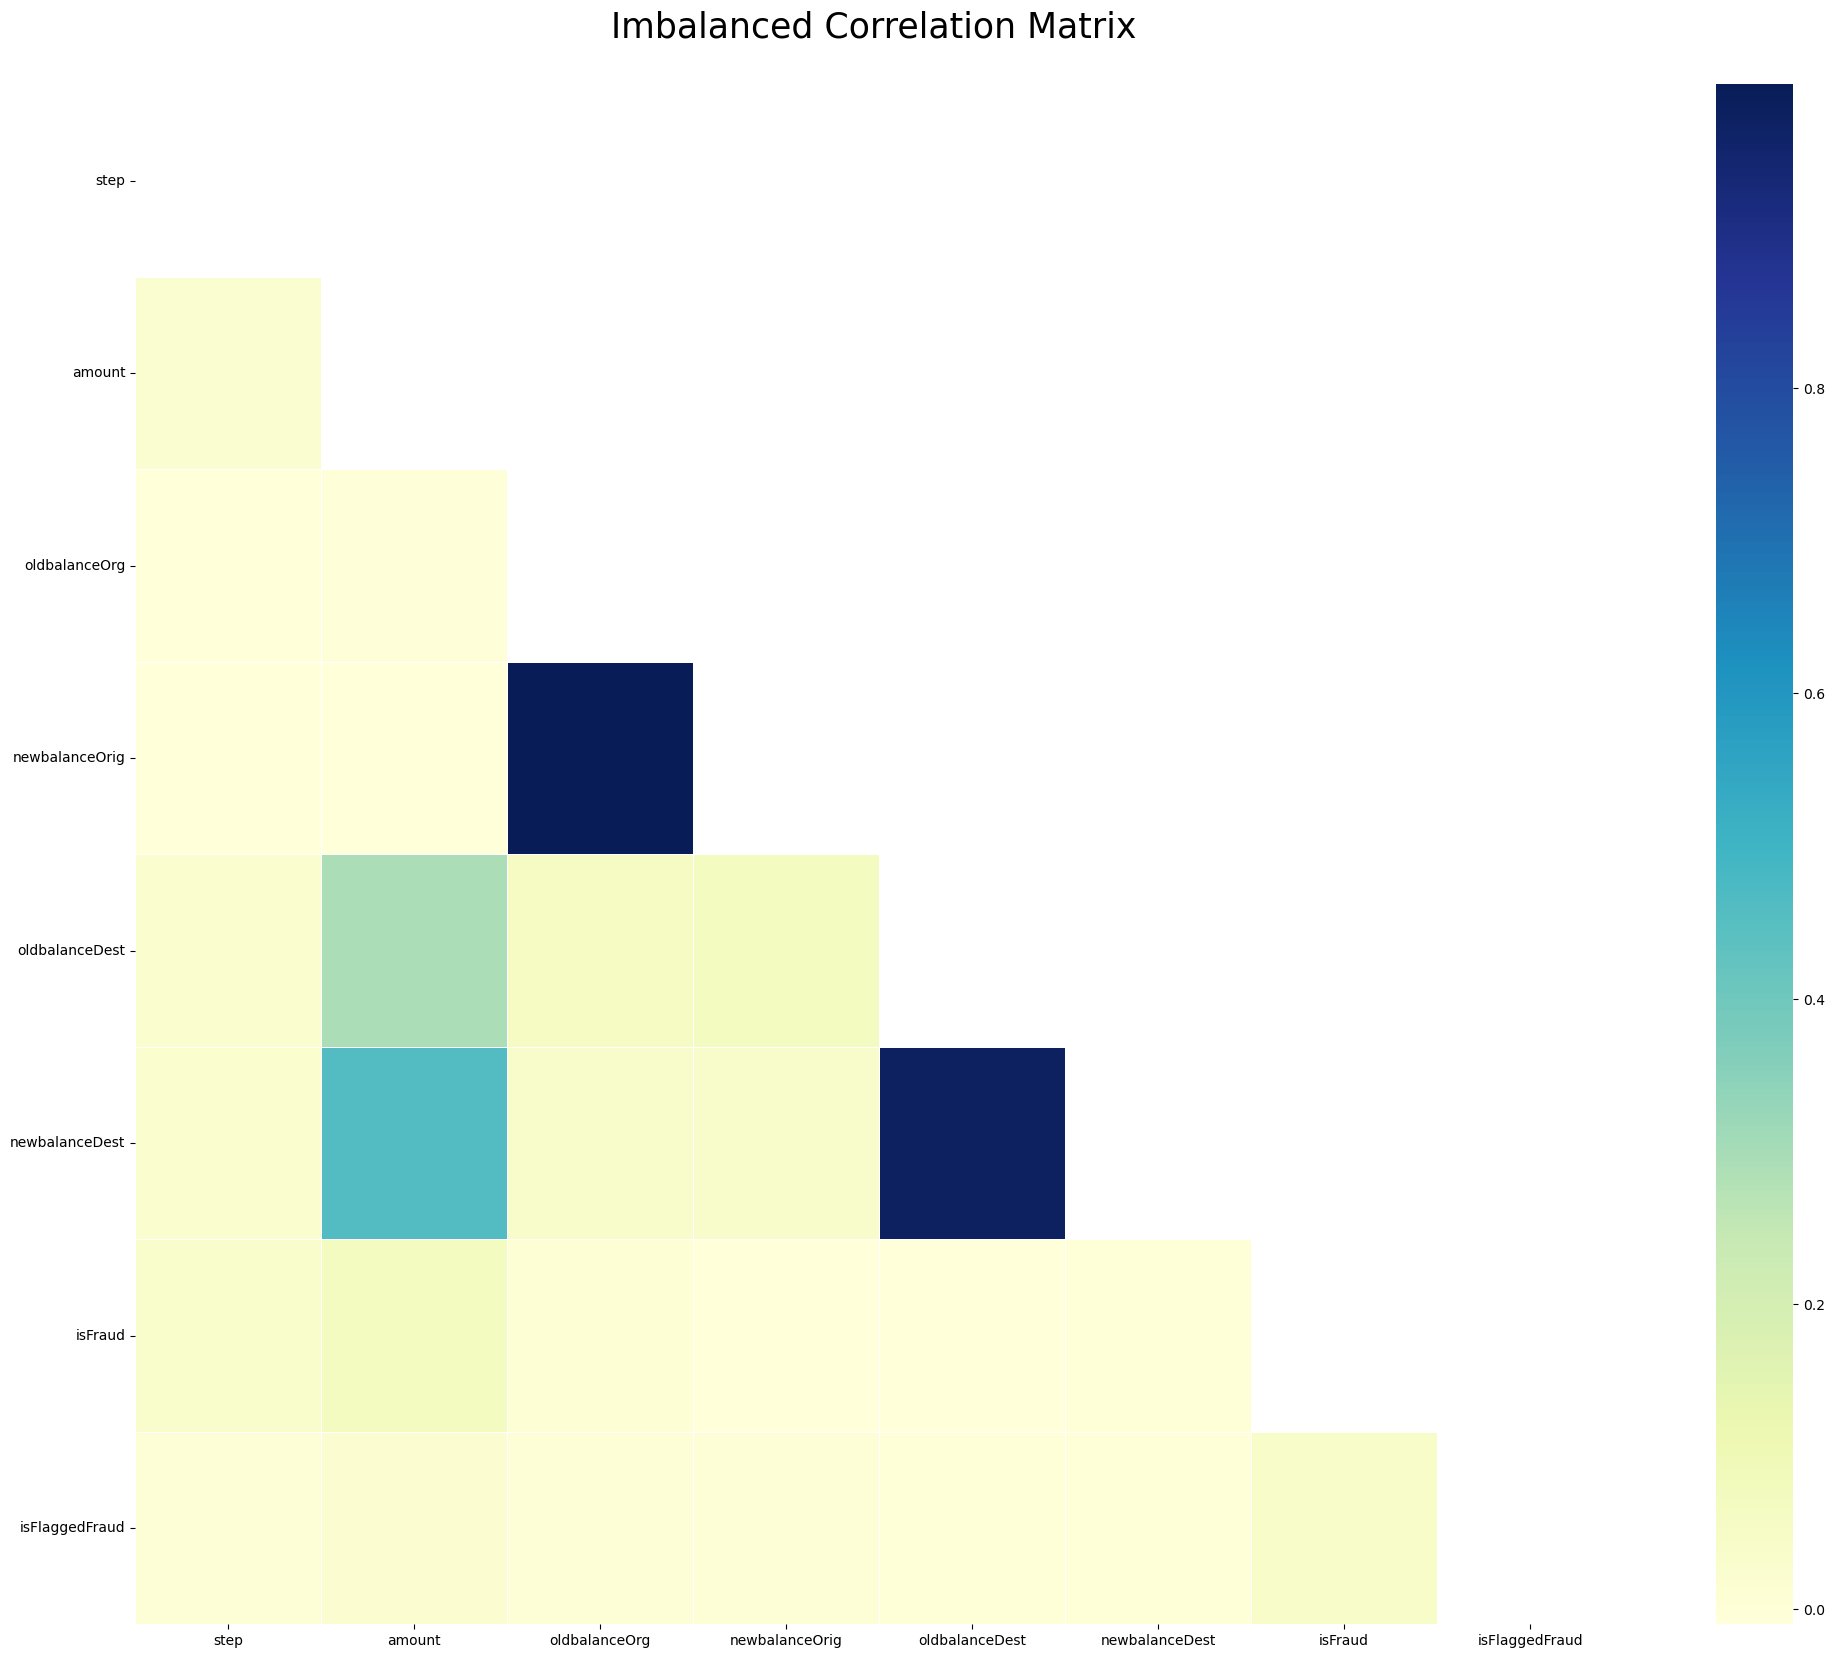

In [58]:
# correlation
f, ax1 = plt.subplots(1, 1, figsize=(24,20))

# Test DataFrame
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':20}, ax=ax1, mask=mask, cbar=True, 
            xticklabels=corr.columns, yticklabels=corr.columns, linewidths=.5)

ax1.set_title("Imbalanced Correlation Matrix \n", fontsize=25)
ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0)


### CLUSTERING TECHNIQUE: KMeans
We want to cluster based on the transaction amount, transaction type, and whether the transaction is fraudulent or not. We can drop the other columns from the dataset and proceed with clustering.

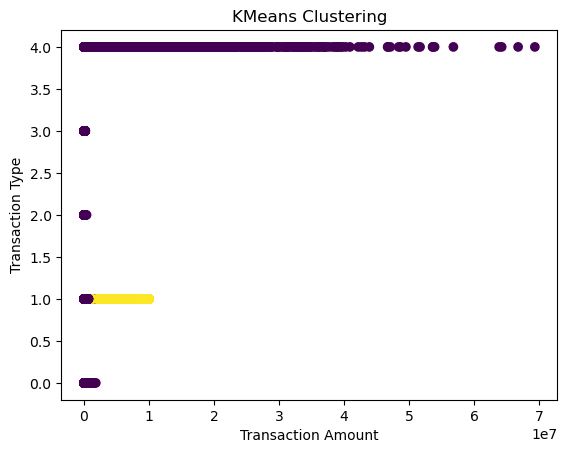

In [59]:
# Select relevant columns for clustering
df_clustering = df[['type', 'amount', 'isFraud']]

# Convert transaction type to categorical variable
df_clustering['type'] = pd.Categorical(df_clustering['type']).codes

# Standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_clustering_std = scaler.fit_transform(df_clustering)

# Perform clustering using KMeans
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(df_clustering_std)

# Visualize the clusters
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(df_clustering['amount'], df_clustering['type'], c=kmeans.labels_)
plt.xlabel('Transaction Amount')
plt.ylabel('Transaction Type')
plt.title('KMeans Clustering')
plt.show()


Here, I added the mask parameter to hide the upper triangular part of the plot, set cbar=True to add a color bar, and set xticklabels and yticklabels to the column names of the correlation matrix for better readability. Finally, I also set linewidths=.5 to make the lines between the cells of the heatmap thinner.

This will perform clustering using KMeans with 2 clusters based on the transaction amount and type, and visualize the clusters. 

In [60]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

for e in numerical:
    df[f'scaled_{e}'] = rob_scaler.fit_transform(df[e].values.reshape(-1,1))
    df.drop([e], axis=1, inplace=True)

In [61]:
df['type'] = df['type'].map({'CASH_OUT':1, 'PAYMENT':2, 'CASH_IN':3, 'TRANSFER':4, 'DEBIT':5})

In [62]:
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

In [63]:
print('No Frauds', round(df['isFraud'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['isFraud'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('isFraud', axis=1)
y = df['isFraud']

sss = StratifiedShuffleSplit(n_splits=5, random_state=None)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

No Frauds 99.87 % of the dataset
Frauds 0.13 % of the dataset
Train: [  42269 1242564  815807 ...  441438 1018259  429576] Test: [  87203  393763  726936 ... 1149777 1036252 1151809]
Train: [ 295612  571934  519396 ...  491822 1265619 1130127] Test: [ 912113 1117705 1114575 ...  779949  990358  261181]
Train: [ 85080 239827 654749 ... 779520 780019  12810] Test: [1068313  872145  419327 ...  156234  927214  564885]
Train: [1234217 1143953  205931 ... 1241555 1070199  188439] Test: [1173815 1271362  170750 ...  718126  654850  319072]
Train: [ 690132 1222849 1003388 ...  836950  320576  579345] Test: [979676 434107  37023 ... 983402  81015 480941]


In [64]:
# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

Label Distributions: 

[0.99872694 0.00127306]
[0.99872695 0.00127305]


In [65]:

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

In [66]:
from sklearn.linear_model import LogisticRegression

X_train = original_Xtrain.copy()
y_train = original_ytrain.copy()
X_test = original_Xtest.copy()
y_test = original_ytest.copy()

clf = LogisticRegression()

# train the model on the training data
clf.fit(X_train, y_train)

# predict on the testing data
y_pred = clf.predict(X_test)

In [67]:
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[127081     10]
 [    96     66]]


In [68]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.407407,0.868421,0.554622,0.999167


In [69]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [70]:
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.9996306570375552


In [28]:
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

[[127089      2]
 [    41    121]]


In [29]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

,Random Forest with,Recall,Precision,F1 Score,Accuracy
0,No Under/Oversampling,0.746914,0.98374,0.849123,0.999662


### SVM (Support Vector Machines)

In [77]:
train, test = train_test_split(df_raw, test_size=0.2, random_state=42)
df = test
print(df.columns)

Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')


#### Select the columns of interest and create a new dataframe:

In [78]:
cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud']

df_new = df[cols]


In [79]:
display(df_new)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
3737323,278,330218.42,20866.00,351084.42,452419.57,122201.15,0
264914,15,11647.08,30370.00,18722.92,0.00,0.00,0
85647,10,152264.21,106589.00,258853.21,201303.01,49038.80,0
5899326,403,1551760.63,0.00,0.00,3198359.45,4750120.08,0
2544263,206,78172.30,2921331.58,2999503.88,415821.90,337649.60,0
...,...,...,...,...,...,...,...
2210524,186,917.99,9606.00,8688.01,0.00,0.00,0
956542,44,480.58,4683.00,4202.42,0.00,0.00,0
5474798,379,248511.67,507.00,0.00,23807.93,272319.61,0
878120,42,200008.65,0.00,0.00,589973.64,789982.29,0


#### Preprocess the dataset by scaling the numeric features. For example, we will use the StandardScaler() function from scikit-learn to scale the numeric variables:

In [80]:
from sklearn.preprocessing import StandardScaler

numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
scaler = StandardScaler()
df_new[numeric_cols] = scaler.fit_transform(df_new[numeric_cols])


#### Split the dataset into training and testing sets using the train_test_split() function from scikit-learn:

In [81]:
from sklearn.model_selection import train_test_split

X = df_new.drop(['isFraud'], axis=1)
y = df_new['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


#### Train the SVM model using the SVC() class from scikit-learn:

In [82]:
from sklearn.svm import SVC

clf = SVC(kernel='linear')
clf.fit(X_train, y_train)


SVC(kernel='linear')

#### Evaluate the performance of the model using appropriate evaluation metrics, such as accuracy, precision, recall, and F1 score. For example, we will use the classification_report() function from scikit-learn to calculate these metrics:

In [42]:
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00    381286
           1       0.99      0.32      0.48       472

    accuracy                           1.00    381758
   macro avg       0.99      0.66      0.74    381758
weighted avg       1.00      1.00      1.00    381758



#### This will give us a report of the precision, recall, and F1 score for each label, as well as the overall accuracy of the model.